# Data exploration

---

This notebook serves as an initial data set exploration sandbox. In particular, we are interested in which ORF experiments are available for each source and what is their intersection with the genes available in a given gene-gene interactome.

---

## 0. Environmental setup

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

from urllib.error import HTTPError

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data



In [8]:
gene_ia_embs = pd.read_csv("other_data/all_gene_embeddings_clusters.csv", index_col=0)
gene_ia_set = set(gene_ia_embs.gene)

<IPython.core.display.Javascript object>

In [9]:
well_data = pd.read_csv("metadata/well.csv")
orf_data = pd.read_csv("metadata/orf.csv")
plate_data = pd.read_csv("metadata/plate.csv")

<IPython.core.display.Javascript object>

---

## 2. Exploratory data analysis

After having read in the data, we will now explore the data. To this end, we will first look at the overlap of experiments targetting genes for overexpression that are part of the gene gene interactome we had derived in the Image2Reg project.

### 2.1. Interactome coverage

In [10]:
all_orf_data = well_data.merge(
    orf_data, right_on="Metadata_JCP2022", left_on="Metadata_JCP2022", how="inner"
)
all_orf_data = all_orf_data.merge(
    plate_data.loc[:, ["Metadata_Plate", "Metadata_Batch", "Metadata_PlateType"]],
    right_on="Metadata_Plate",
    left_on="Metadata_Plate",
)
all_orf_data.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Batch,Metadata_PlateType
0,source_4,BR00117035,A01,JCP2022_905588,ccsbBroad304_05979,ORF000779.1_TRC304.1,pLX_304,NM_001261.4,CDK9,1025,9606,cyclin dependent kinase 9,100.0,1116.0,trt,2021_04_26_Batch1,ORF
1,source_4,BR00117035,A02,JCP2022_912241,ccsbBroad304_13129,ORF007469.1_TRC304.1,pLX_304,NM_001352984.2,HMGB4,127540,9606,high mobility group box 4,99.1,336.0,trt,2021_04_26_Batch1,ORF
2,source_4,BR00117035,A03,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,843.0,trt,2021_04_26_Batch1,ORF
3,source_4,BR00117035,A04,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon,2021_04_26_Batch1,ORF
4,source_4,BR00117035,J21,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon,2021_04_26_Batch1,ORF


<IPython.core.display.Javascript object>

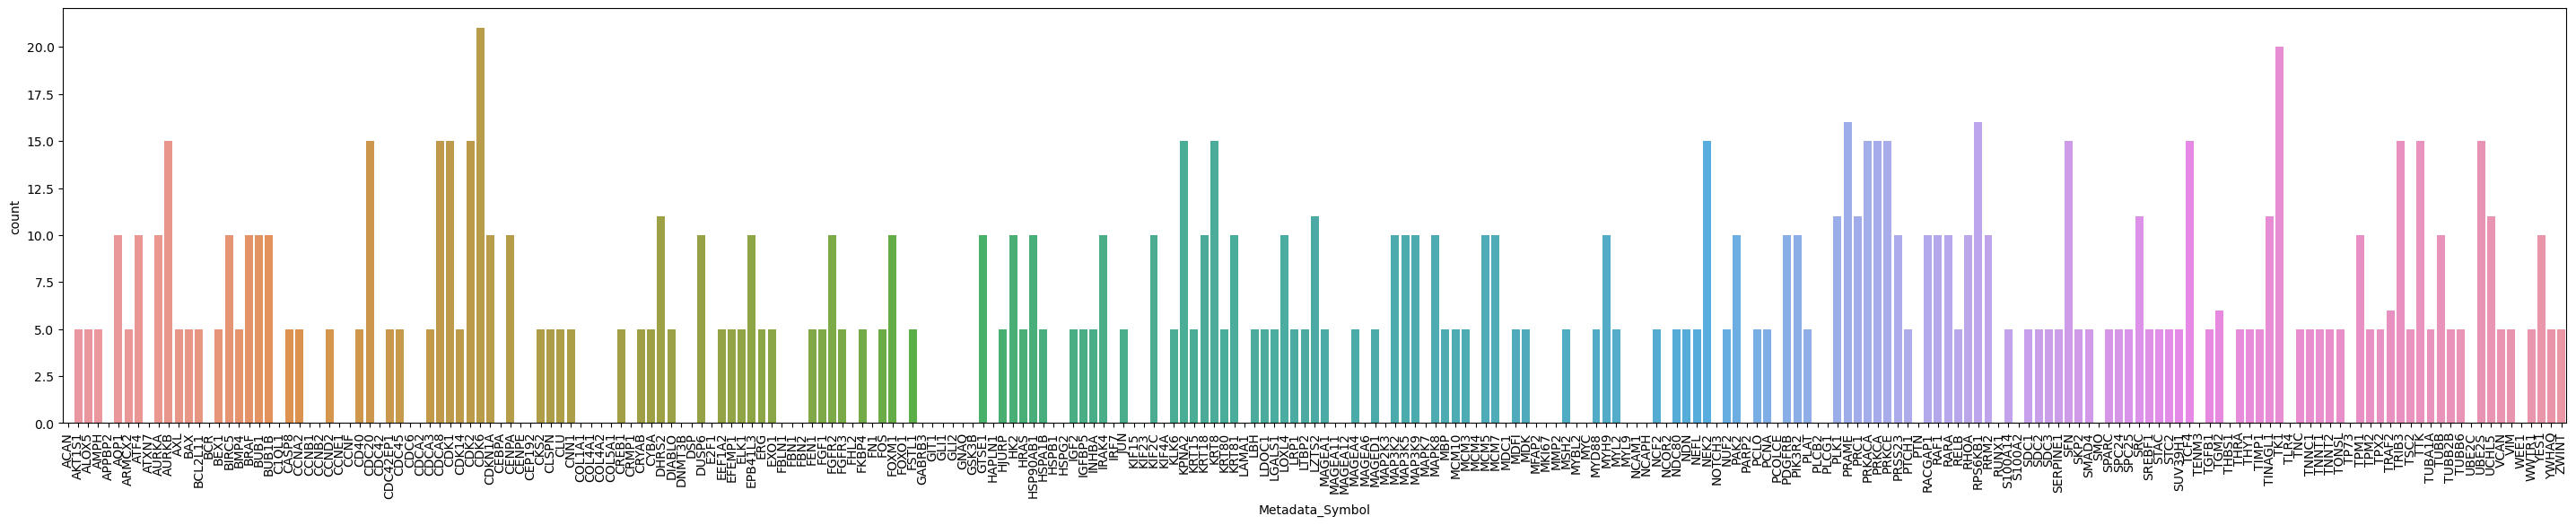

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(figsize=[36, 6])
ax = sns.countplot(
    data=all_orf_data.loc[all_orf_data.Metadata_Symbol.isin(gene_ia_set)],
    x="Metadata_Symbol",
    order=sorted(gene_ia_set),
    # hue="Metadata_Batch",
)
plt.xticks(rotation=90)
plt.show()

As seen in the plot the JCP data set contains many of overexpression experiments that target the genes covered in the gene-gene interactome.

In total 175/249 genes are covered with an average of 7.61 +/- 3.70 wells for each as seen below.

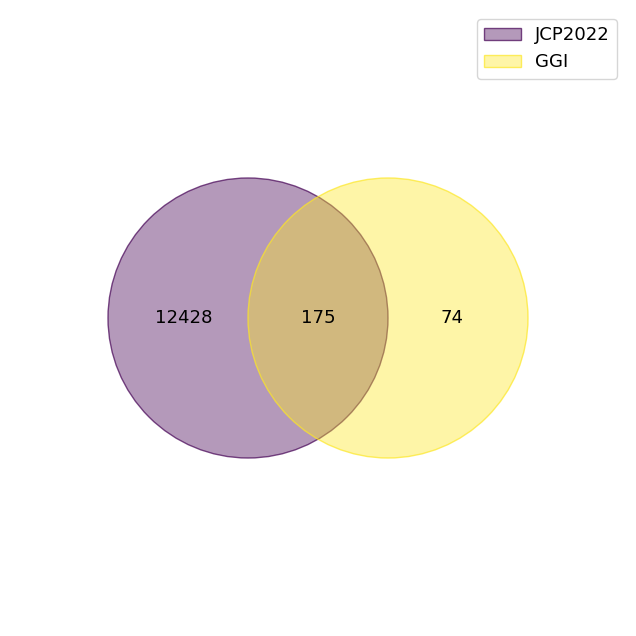

<IPython.core.display.Javascript object>

In [12]:
jcp_gene_list = set(all_orf_data.Metadata_Symbol)
ax = venn({"JCP2022": jcp_gene_list, "GGI": gene_ia_set})
plt.show()

In [13]:
all_orf_data.loc[all_orf_data.Metadata_Symbol.isin(gene_ia_set)].groupby(
    "Metadata_Symbol"
).count().Metadata_Source.describe()

count    175.000000
mean       7.611429
std        3.701178
min        5.000000
25%        5.000000
50%        5.000000
75%       10.000000
max       21.000000
Name: Metadata_Source, dtype: float64

<IPython.core.display.Javascript object>

It is important to mention that these were obtained from different experimental batches and potential batch effects need to be investigated.

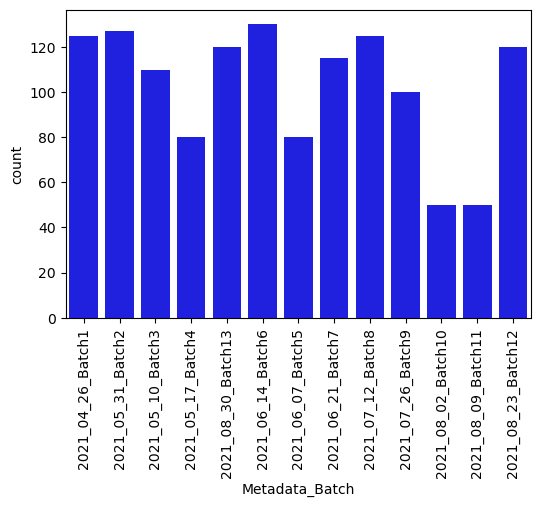

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.countplot(
    data=all_orf_data.loc[all_orf_data.Metadata_Symbol.isin(gene_ia_set)],
    x="Metadata_Batch",
    # order=sorted(gene_ia_list),
    # hue="Metadata_Batch",
    palette=["b"],
)
plt.xticks(rotation=90)
plt.show()

---

### 2.2. Data set size

We will now further assess the dimensions of the data set by checking how many nuclei are available for each overexpression condition covered in our GGI.

In [15]:
corf_data = all_orf_data.loc[
    all_orf_data.Metadata_Symbol.isin(gene_ia_set)
].sort_values(["Metadata_Plate", "Metadata_Well"])
corf_data.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Batch,Metadata_PlateType
103,source_4,BR00117035,E06,JCP2022_900331,ccsbBroad304_00360,ORF000135.1_TRC304.1,pLX_304,NM_134442.5,CREB1,1385,9606,cAMP responsive element binding protein 1,100.0,1023.0,trt,2021_04_26_Batch1,ORF
138,source_4,BR00117035,F18,JCP2022_902710,ccsbBroad304_02889,ORF010172.1_TRC304.1,pLX_304,NM_001348362.1,WWTR1,25937,9606,WW domain containing transcription regulator 1,100.0,1200.0,trt,2021_04_26_Batch1,ORF
180,source_4,BR00117035,H11,JCP2022_905780,ccsbBroad304_06179,ORF014130.1_TRC304.1,pLX_304,NM_182918.4,ERG,2078,9606,ETS transcription factor ERG,73.6,1428.0,trt,2021_04_26_Batch1,ORF
222,source_4,BR00117035,J05,JCP2022_900466,ccsbBroad304_00498,ORF005645.1_TRC304.1,pLX_304,NM_001114123.2,ELK1,2002,9606,ETS transcription factor ELK1,100.0,1284.0,trt,2021_04_26_Batch1,ORF
469,source_4,BR00117036,E06,JCP2022_900331,ccsbBroad304_00360,ORF000135.1_TRC304.1,pLX_304,NM_134442.5,CREB1,1385,9606,cAMP responsive element binding protein 1,100.0,1023.0,trt,2021_04_26_Batch1,ORF


<IPython.core.display.Javascript object>

In total 1,332 wells were imaged for our 175 genes. For each well we will have 9 images forming a total size of 11,988 images that will form the new data set spread across 232 plates.

---

We will now scrape the corresponding image-level profile information from the AWS bucket that give us a first indication on how many nuclei per condition we are looking at although the actual number might differ as we will use our own segmentation model.

In [71]:
image_profile_formatter = (
    "https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/"
    "{Metadata_Source}/workspace/analysis/{Metadata_Batch}/{Metadata_Plate}/analysis/{Metadata_Plate}-{Metadata_Well}-{Metadata_Site}/Image.csv"
)

<IPython.core.display.Javascript object>

In [107]:
def get_image_data(entry):
    img_dfs = []
    entry_dict["Metadata_Source"] = entry.Metadata_Source
    entry_dict["Metadata_Plate"] = entry.Metadata_Plate
    entry_dict["Metadata_Well"] = entry.Metadata_Well
    entry_dict["Metadata_Batch"] = entry.Metadata_Batch
    for i in range(1, 10):
        entry_dict["Metadata_Site"] = i
        s3_path = image_profile_formatter.format(**entry_dict)
        try:
            img_df = pd.read_csv(s3_path)
            img_df["Metadata_Site"] = i
            img_df["Metadata_Source"] = entry_dict["Metadata_Source"]
            img_df["Metadata_Plate"] = entry_dict["Metadata_Plate"]
            img_df["Metadata_Well"] = entry_dict["Metadata_Well"]
            img_df["Metadata_Batch"] = entry_dict["Metadata_Batch"]
        except HTTPError:
            print("URL not found:", s3_path)
            img_df = pd.DataFrame(
                entry_dict, index=["{}_{}".format(entry.Metadata_JCP2022, i)]
            )
        img_dfs.append(img_df)
    all_img_df = pd.concat(img_dfs)
    return all_img_df

<IPython.core.display.Javascript object>

In [108]:
all_img_dfs = Parallel(n_jobs=20)(
    delayed(get_image_data)(corf_data.iloc[i]) for i in tqdm(range(len(corf_data)))
)

  0%|          | 0/1332 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [109]:
all_img_dfs = pd.concat(all_img_dfs)

<IPython.core.display.Javascript object>

In [128]:
all_img_dfs

,Count_Cells,Count_CellsIncludingEdges,Count_Cytoplasm,Count_Nuclei,Count_NucleiIncludingEdges,ExecutionTime_01LoadData,ExecutionTime_02CorrectIlluminationApply,ExecutionTime_03MeasureImageQuality,ExecutionTime_04MeasureImageQuality,ExecutionTime_06CorrectIlluminationCalculate,...,Width_OrigER,Width_OrigMito,Width_OrigRNA,Metadata_Source,Metadata_Batch,source,plate,well,batch,img
0,84.0,92.0,84.0,84.0,92.0,9.36,0.14,15.73,0.44,1.03,...,1080.0,1080.0,1080.0,source_4,2021_04_26_Batch1,NaN,NaN,NaN,NaN,NaN
0,164.0,181.0,164.0,164.0,181.0,8.80,0.17,14.59,0.43,1.04,...,1080.0,1080.0,1080.0,source_4,2021_04_26_Batch1,NaN,NaN,NaN,NaN,NaN
0,148.0,166.0,148.0,148.0,166.0,9.52,0.16,16.57,0.46,1.05,...,1080.0,1080.0,1080.0,source_4,2021_04_26_Batch1,NaN,NaN,NaN,NaN,NaN
0,205.0,225.0,205.0,205.0,225.0,8.85,0.09,15.03,0.45,0.99,...,1080.0,1080.0,1080.0,source_4,2021_04_26_Batch1,NaN,NaN,NaN,NaN,NaN
0,143.0,158.0,143.0,143.0,158.0,8.83,0.22,15.41,0.43,1.02,...,1080.0,1080.0,1080.0,source_4,2021_04_26_Batch1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,65.0,76.0,65.0,65.0,76.0,8.81,0.09,15.62,0.42,1.08,...,1080.0,1080.0,1080.0,source_4,2021_08_23_Batch12,NaN,NaN,NaN,NaN,NaN
0,71.0,76.0,71.0,71.0,76.0,9.75,0.08,16.05,0.42,1.03,...,1080.0,1080.0,1080.0,source_4,2021_08_23_Batch12,NaN,NaN,NaN,NaN,NaN
0,48.0,56.0,48.0,48.0,56.0,7.73,0.07,14.43,0.41,1.00,...,1080.0,1080.0,1080.0,source_4,2021_08_23_Batch12,NaN,NaN,NaN,NaN,NaN
0,57.0,67.0,57.0,57.0,67.0,7.81,0.07,15.62,0.42,0.99,...,1080.0,1080.0,1080.0,source_4,2021_08_23_Batch12,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [110]:
all_img_dfs.to_csv("metadata/covered_image_data.csv.gz")

<IPython.core.display.Javascript object>

---

We will also add the corresponding image file locations and the links to the illumination correction functions to the data to check if all such information are available.

In [56]:
loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{source}/workspace/load_data_csv/"
    "{batch}/{plate}/load_data_with_illum.csv.gz"
)

<IPython.core.display.Javascript object>

In [64]:
def get_image_loc_data(entry):
    img_loc_dfs = []
    entry_dict["source"] = entry.Metadata_Source
    entry_dict["plate"] = entry.Metadata_Plate
    entry_dict["well"] = entry.Metadata_Well
    entry_dict["batch"] = entry.Metadata_Batch
    s3_path = loaddata_formatter.format(**entry_dict)
    try:
        img_loc_df = pd.read_csv(s3_path)
    except HTTPError:
        print("URL not found:", s3_path)
    img_loc_dfs.append(img_loc_df)
    all_img_loc_df = pd.concat(img_loc_dfs)
    return all_img_loc_df

<IPython.core.display.Javascript object>

In [66]:
all_img_loc_dfs = Parallel(n_jobs=10)(
    delayed(get_image_loc_data)(corf_data.iloc[i]) for i in tqdm(range(len(corf_data)))
)

  0%|          | 0/1332 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [96]:
all_img_loc_df = pd.concat(all_img_loc_dfs)

<IPython.core.display.Javascript object>

In [119]:
all_img_data = pd.merge(
    all_img_dfs,
    all_img_loc_df,
    on=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ],
).merge(
    corf_data,
    on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
)

<IPython.core.display.Javascript object>

In [129]:
all_img_data.loc[
    :,
    list(
        set(
            [
                "Metadata_Source",
                "Metadata_Batch",
                "Metadata_Plate",
                "Metadata_Well",
                "Metadata_Site",
                "Count_Nuclei",
            ]
        ).union(corf_data.columns)
    )
    + [col for col in all_img_data if col.startswith("FileName")]
    + [col for col in all_img_data if col.startswith("PathName")],
]

,Metadata_Site,Metadata_pert_type,Metadata_Batch,Metadata_JCP2022,Metadata_NCBI_Gene_ID,Metadata_Gene_Description,Metadata_Taxon_ID,Metadata_Symbol,Metadata_Plate,Metadata_Vector,...,PathName_IllumAGP_y,PathName_IllumDNA_y,PathName_IllumER_y,PathName_IllumMito_y,PathName_IllumRNA_y,PathName_OrigAGP_y,PathName_OrigDNA_y,PathName_OrigER_y,PathName_OrigMito_y,PathName_OrigRNA_y
0,1,trt,2021_04_26_Batch1,JCP2022_900331,1385,cAMP responsive element binding protein 1,9606,CREB1,BR00117035,pLX_304,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
1,1,trt,2021_04_26_Batch1,JCP2022_900331,1385,cAMP responsive element binding protein 1,9606,CREB1,BR00117035,pLX_304,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
2,1,trt,2021_04_26_Batch1,JCP2022_900331,1385,cAMP responsive element binding protein 1,9606,CREB1,BR00117035,pLX_304,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
3,1,trt,2021_04_26_Batch1,JCP2022_900331,1385,cAMP responsive element binding protein 1,9606,CREB1,BR00117035,pLX_304,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
4,2,trt,2021_04_26_Batch1,JCP2022_900331,1385,cAMP responsive element binding protein 1,9606,CREB1,BR00117035,pLX_304,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95042,9,trt,2021_08_23_Batch12,JCP2022_910236,4627,NaN,9606,MYH9,BR00126718,pLX_304,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-ju

<IPython.core.display.Javascript object>

In [132]:
all_img_data.to_hdf("metadata/covered_image_data_all.h5", key="data")

/tmp/ipykernel_210081/2236374810.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['FileName_CellOutlines', 'FileName_IllumAGP_x',
       'FileName_IllumBrightfield', 'FileName_IllumBrightfield_H',
       'FileName_IllumBrightfield_L', 'FileName_IllumDNA_x',
       'FileName_IllumER_x', 'FileName_IllumMito_x', 'FileName_IllumRNA_x',
       'FileName_NucleiOutlines',
       ...
       'Metadata_broad_sample', 'Metadata_Name', 'Metadata_Vector',
       'Metadata_Transcript', 'Metadata_Symbol', 'Metadata_NCBI_Gene_ID',
       'Metadata_Taxon_ID', 'Metadata_Gene_Description', 'Metadata_pert_type',
       'Metadata_PlateType'],
      dtype='object', length=109)]

  all_img_data.to_hdf("metadata/covered_image_data_all.h5", key="data")


<IPython.core.display.Javascript object>

/tmp/ipykernel_210081/1210037295.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_img_data.groupby("Metadata_Symbol").sum().Count_Nuclei.sort_values(


<AxesSubplot: xlabel='Metadata_Symbol'>

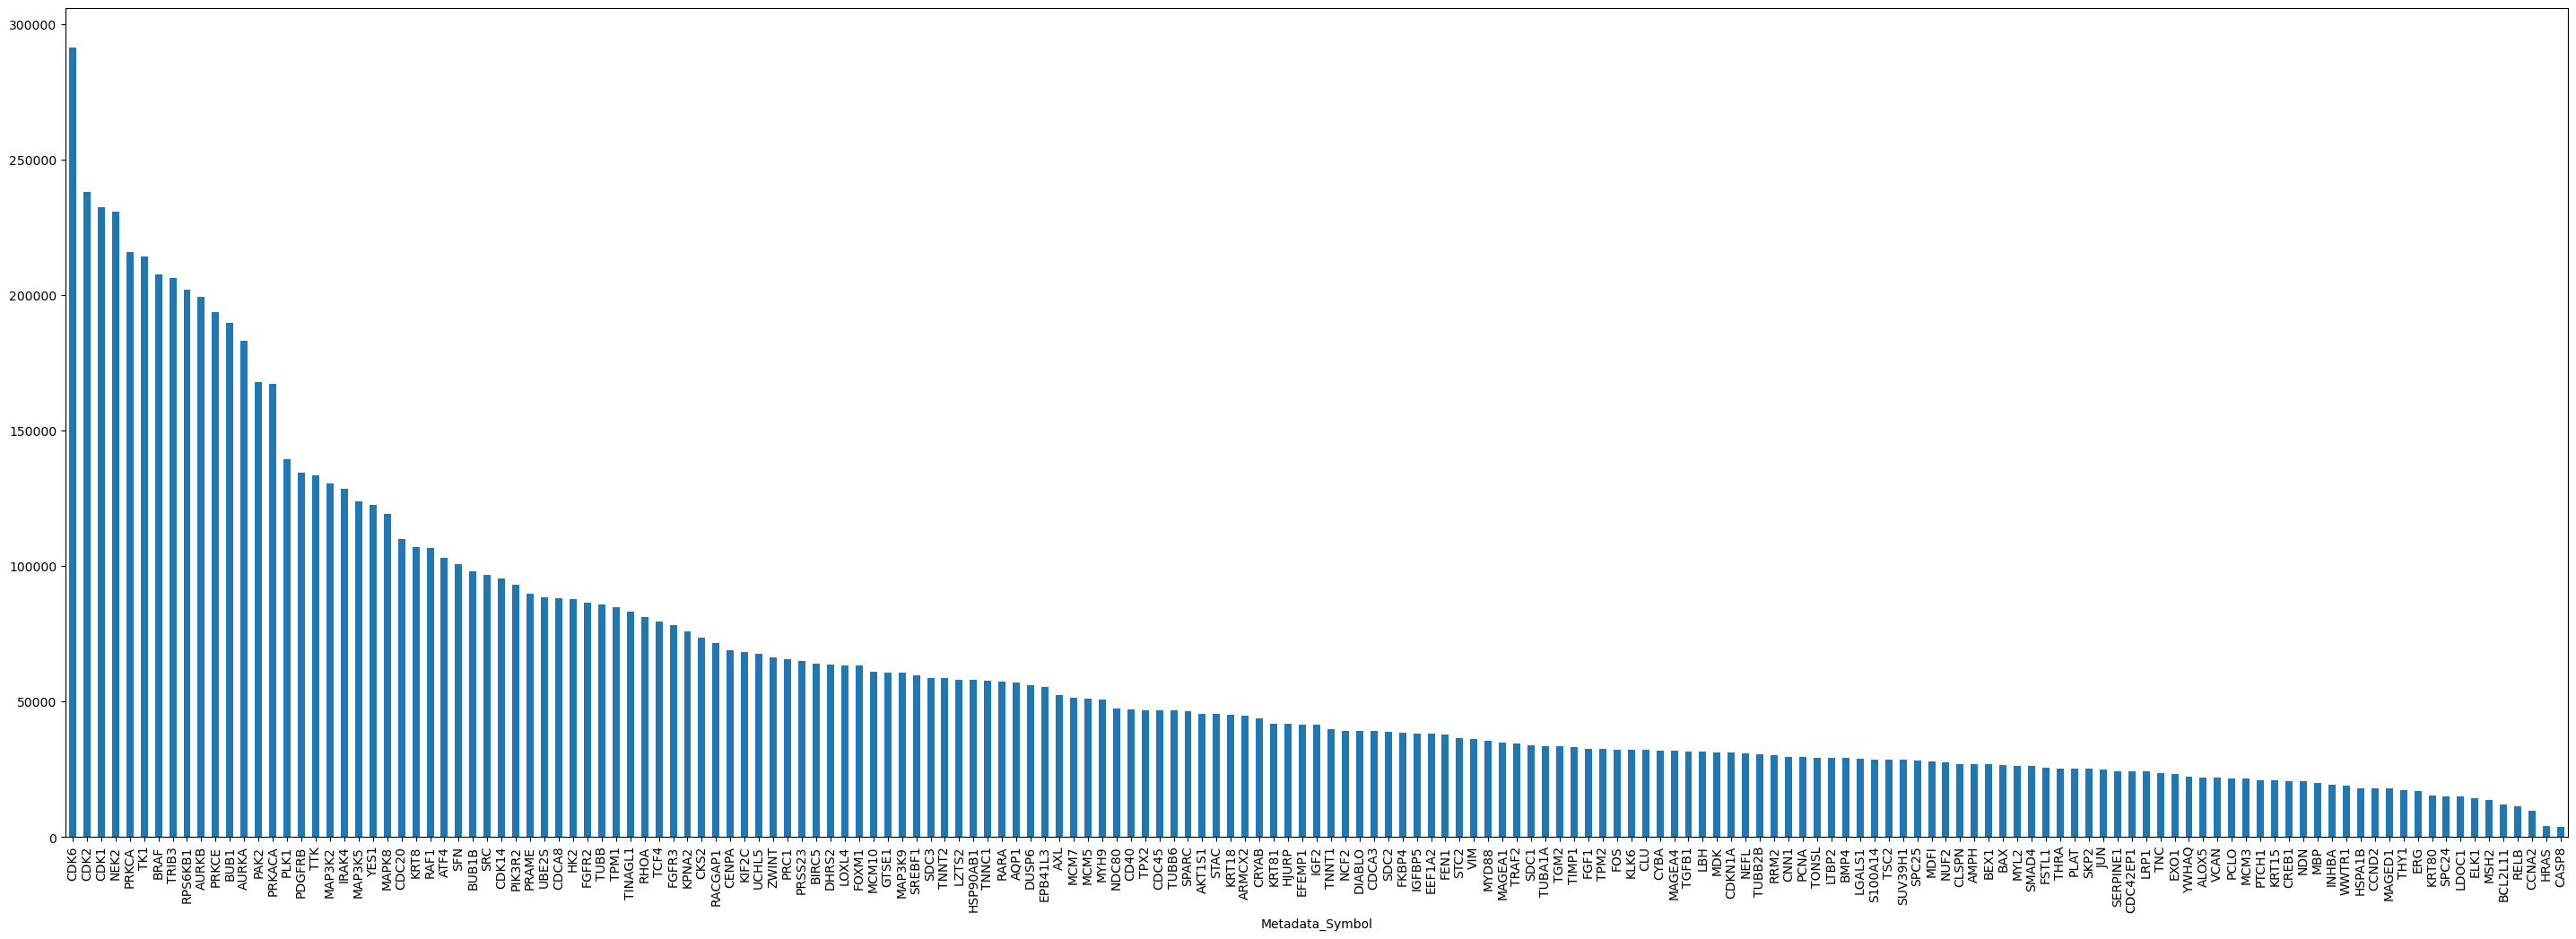

<IPython.core.display.Javascript object>

In [144]:
all_img_data.groupby("Metadata_Symbol").sum().Count_Nuclei.sort_values(
    ascending=False
).plot(kind="bar", figsize=[36, 12])

In [156]:
all_img_data.groupby("Metadata_Symbol").sum().Count_Nuclei.sum()

/tmp/ipykernel_210081/1619309120.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_img_data.groupby("Metadata_Symbol").sum().Count_Nuclei.sum()


10842271.0

<IPython.core.display.Javascript object>

In [150]:
"RAF1" in list(all_img_data.Metadata_Symbol)

True

<IPython.core.display.Javascript object>